# House Prices: Advanced Regression Techniques  

Task: predict the final price of each home in Ames, Iowa, based on 79 variables.

A detailed description of the problem can be found in https://www.kaggle.com/c/house-prices-advanced-regression-techniques .

In [1]:
import sys
print (sys.version)

3.6.2 |Anaconda, Inc.| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression, RANSACRegressor, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.metrics import r2_score

from sklearn import utils, base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from src.Transformers_01 import my_AppCopy, my_Dummyrizer, my_StdScaler, my_CreateNewFeatures, my_DropFeatures, my_log1p_trf

# Data preparation

In [3]:
# change the directory
df = pd.read_csv(r'housing_prices\kaggle_houses_train.csv', sep=',').drop_duplicates().drop({"Id"},axis=1)

# change the type of some columns whose values can be only integers to 'object' in order to interpret them later as categorical variables
df['MSSubClass'] = df['MSSubClass'].astype(object) # MSSubClass is a categorical variable !
df['MoSold']     = df['MoSold'].astype(object)
df['SalePrice']  = df['SalePrice'].astype(float)

# clean some outliers
df = df.drop( df[ df['LotArea']>100000  ].index.values )
df = df.drop( df[ df['TotalBsmtSF']>5000].index.values )

                         # the first 3 have nan-values the last 2 are highly correlated with other features
cols_to_drop           = ['LotFrontage','MasVnrArea','GarageYrBlt', 'GarageCars', 'TotRmsAbvGrd']

relevant_cols          = df.drop(['SalePrice'],1).columns.values
relevant_cols          = [col for col in relevant_cols if col not in cols_to_drop]

relevant_cols_obj      = [ col for col in relevant_cols if np.result_type(df[col])=='object']
relevant_cols_to_scale = [ col for col in relevant_cols if np.result_type(df[col])!='object']

                         # these cols are usd to create new features with values {1,0}
cols_new_features      = ['LotArea', 'YearBuilt', '2ndFlrSF', 'LowQualFinSF', 'EnclosedPorch', \
                          'OpenPorchSF', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch']



X, Y = utils.shuffle(df.drop(['SalePrice'], axis=1), df['SalePrice'], random_state=41)

# Plots

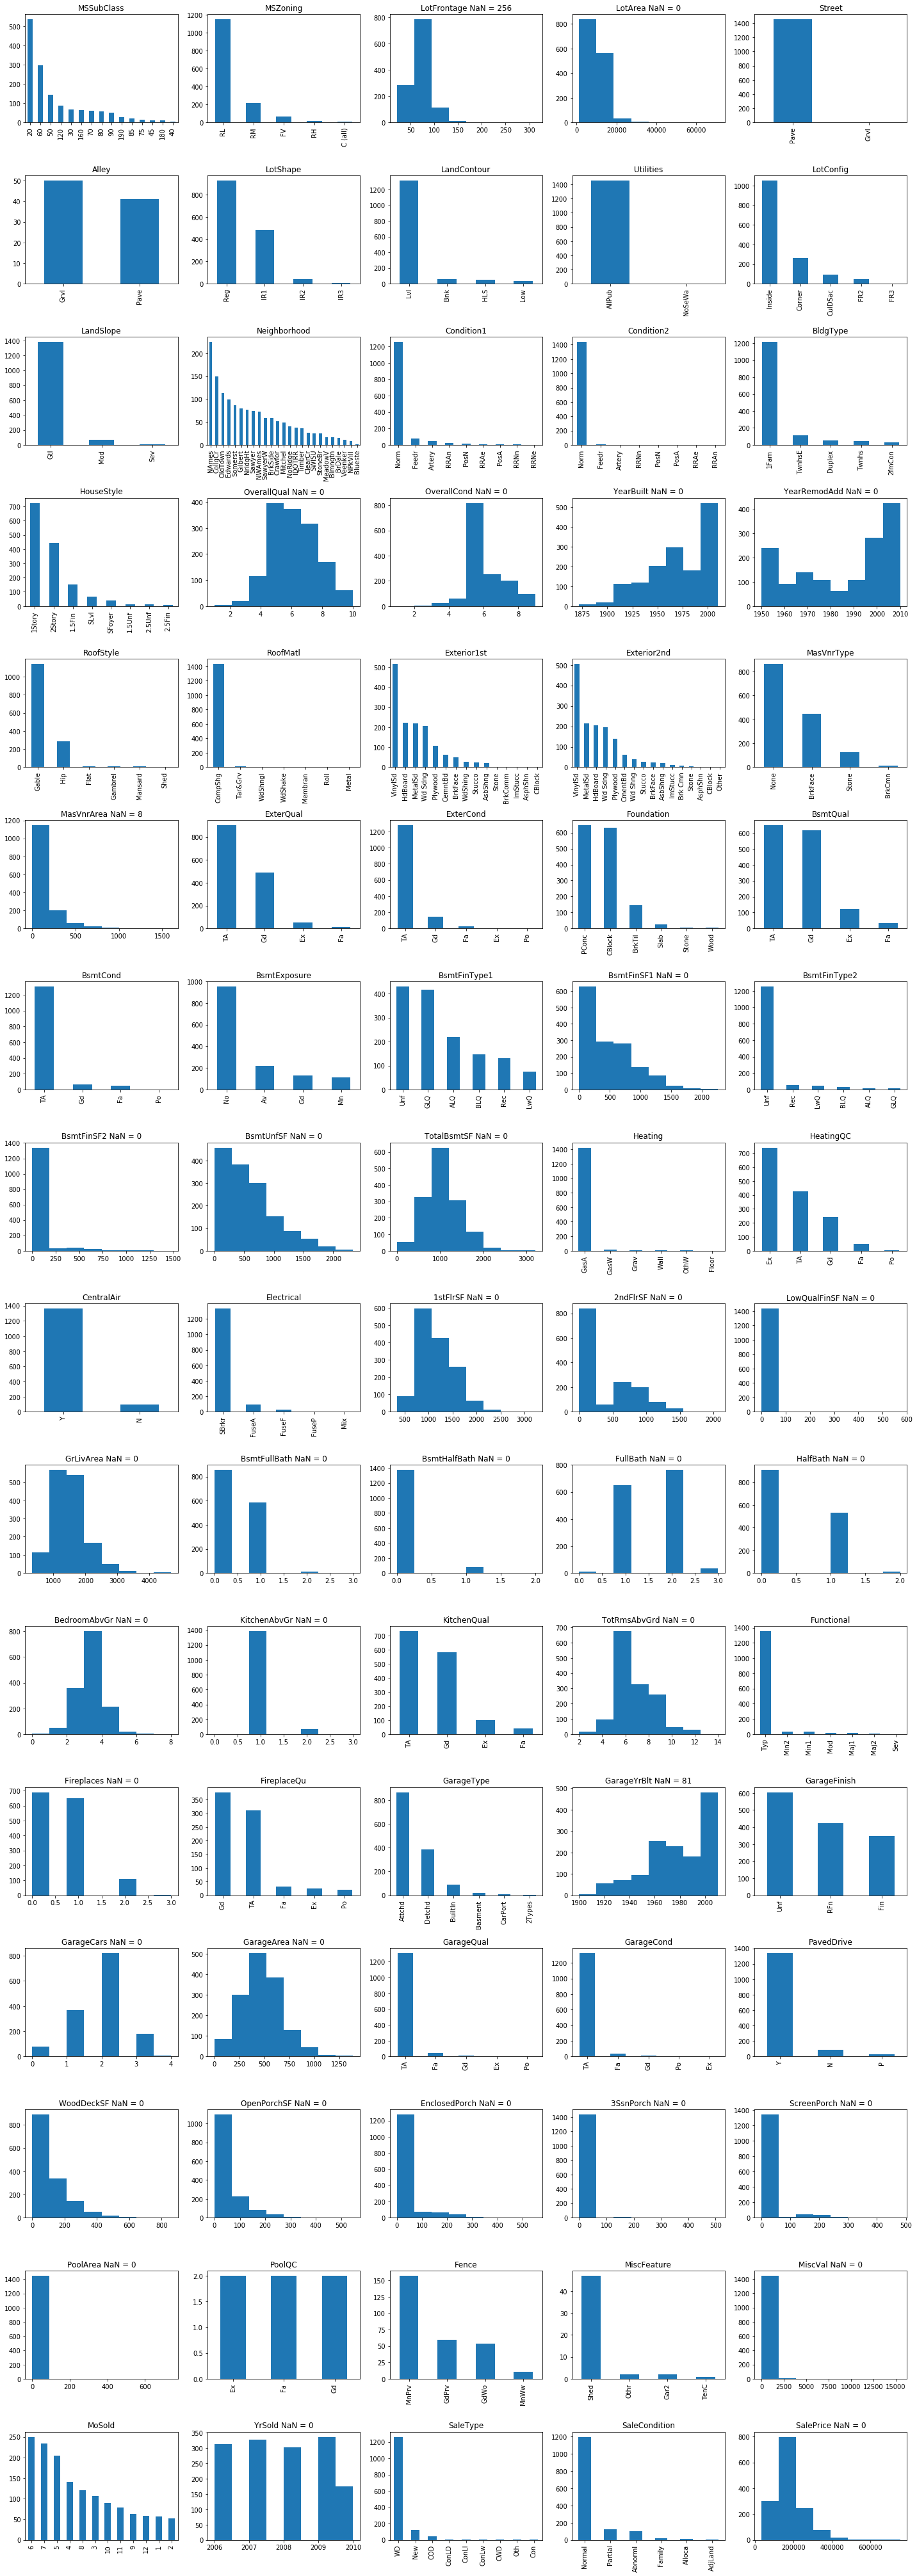

In [25]:
titles = list(df.columns.values)

plt.figure(figsize=(20,7*8))

for idx, col in enumerate(titles):
    
    plt.subplot(16,5,idx+1)

    if "object" == np.result_type(df[col]):
        df[col].value_counts().plot(kind='bar')
        plt.title(col)
    else:
        plt.hist( df[col][ df[col].isnull()==False ], bins=8 )
        plt.title( col + " NaN = " + str(len(df[col][ df[col].isnull()==True ])))
    plt.tight_layout()
    
plt.show()

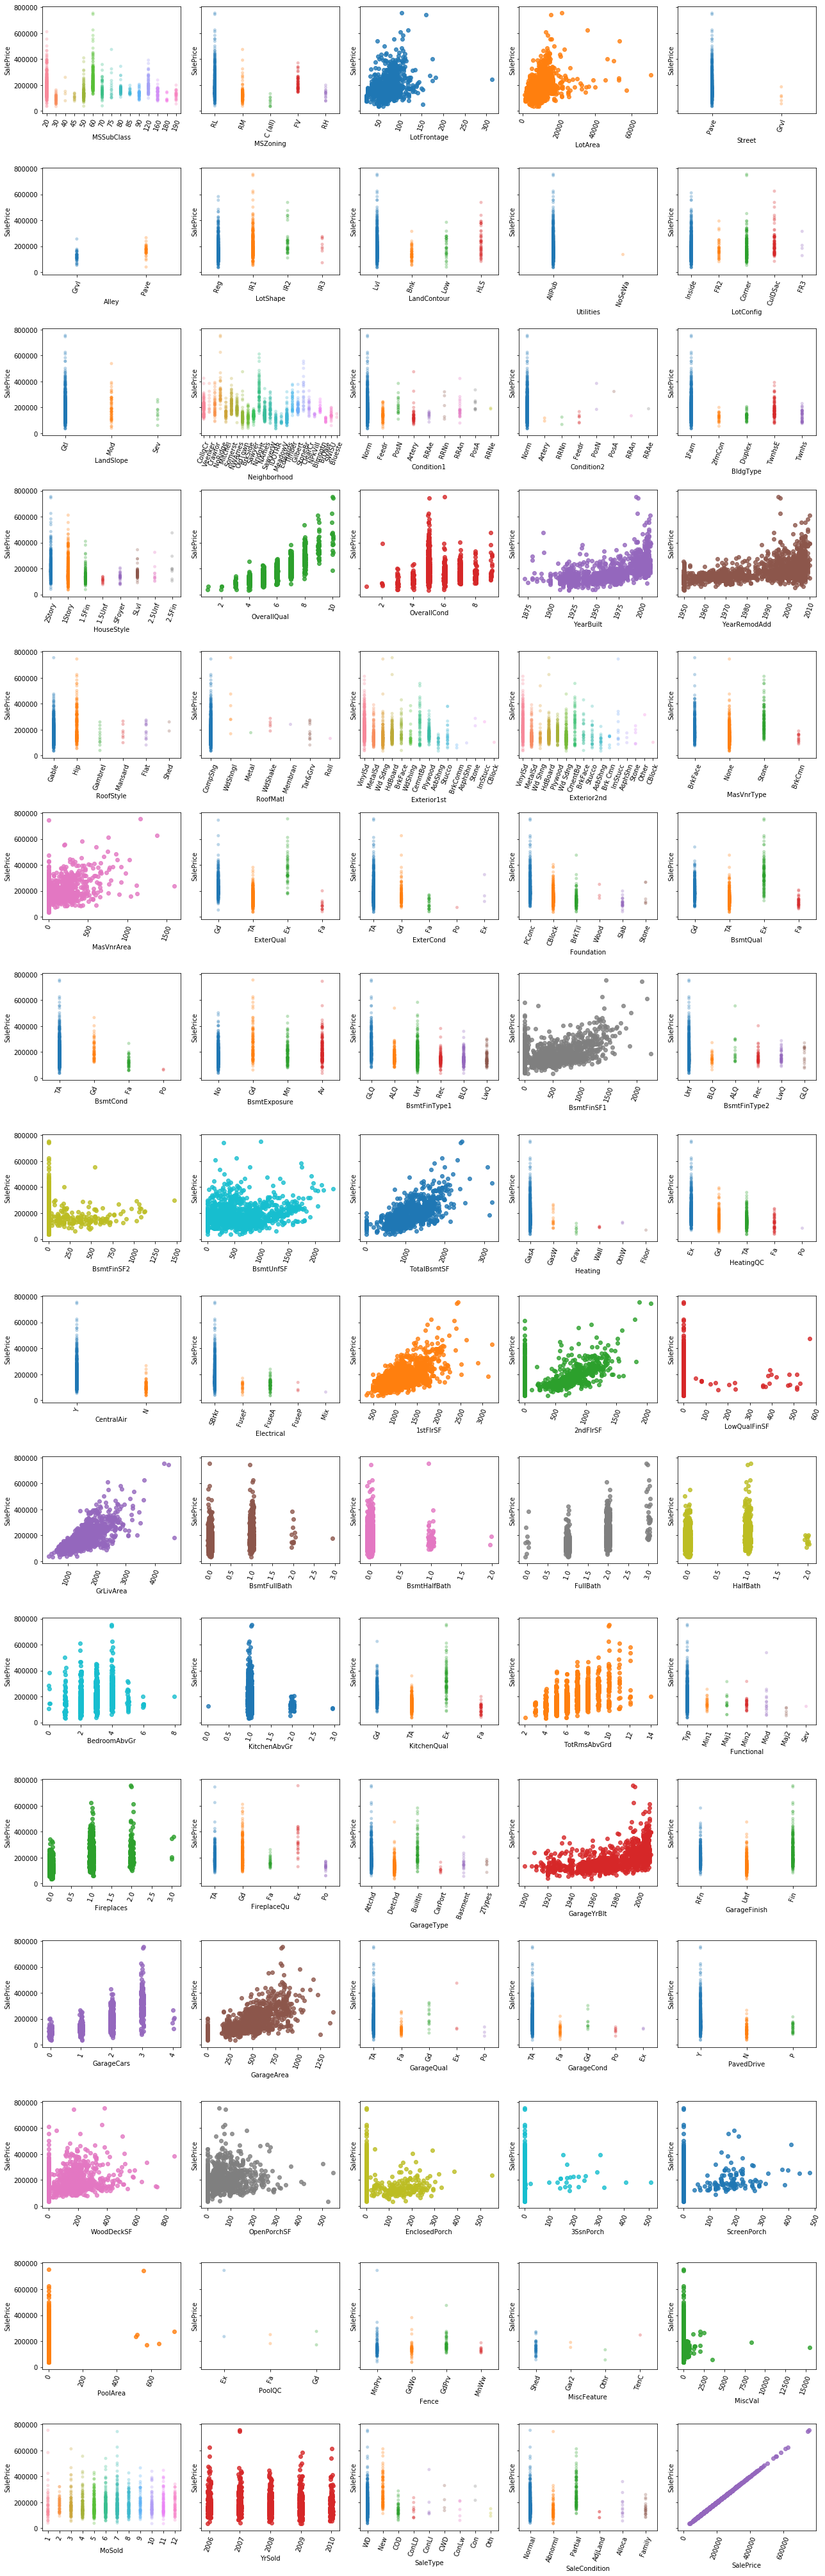

In [27]:
titles = list(df.columns.values)

fig, AX = plt.subplots(16, 5, sharey=True)
fig.set_size_inches(18,8*7)

for idx, col in enumerate(titles):
    
    if "object" == np.result_type(df[col]):
        g=sns.stripplot(x=str(col), y="SalePrice", data = df,                ax=AX[int(idx/5),idx%5], alpha=0.3);
    else:
        g=sns.regplot(  x=str(col), y="SalePrice", data = df, fit_reg=False, ax=AX[int(idx/5),idx%5], x_jitter=0.05);
        
    plt.setp( AX[int(idx/5),idx%5].xaxis.get_majorticklabels(), rotation=70 )
    plt.tight_layout()
    
plt.show()

From the plots we can see that we can constuct several new features (implemented in src.Transformers_01.my_CreateNewFeatures() ):

# Knn with dimensional reduction of the features with type=='object'   

**svd_components = 40**

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

knn_pipeA = Pipeline([
                ('my_AppCopy', my_AppCopy(          relevant_cols = cols_new_features + relevant_cols_obj)),
                ('my_CreateNewFeatures', my_CreateNewFeatures()),
                ('my_DropFeatures', my_DropFeatures(relevant_cols = cols_new_features)),    
                ('my_Dummyriser', my_Dummyrizer(    relevant_cols = relevant_cols_obj)),
                ('my_svd', TruncatedSVD(n_components=40))
                ])

knn_pipeB = Pipeline([
                ('my_AppCopy', my_AppCopy(    relevant_cols = relevant_cols_to_scale)),
                ('my_StdScaler', my_StdScaler(relevant_cols = relevant_cols_to_scale))
                ])

knn_union = FeatureUnion([
                ('my_pipeA', knn_pipeA),
                ('my_pipeB', knn_pipeB) 
                ])

knn_union.set_params(my_pipeA__my_svd__n_components = 40)
knn_union.fit(X_train)

scalerY = StandardScaler().fit(Y_train.values.reshape(-1, 1))

XX_train = knn_union.transform(X_train)
XX_test  = knn_union.transform(X_test)

YY_train = scalerY.transform(Y_train.values.reshape(-1, 1))
YY_test  = scalerY.transform(Y_train.values.reshape(-1, 1))




############################## GridSearch ###############################

my_knn = KNeighborsRegressor(weights='uniform', p=2, n_jobs=-1)

parameter_grid = {'n_neighbors':np.arange(2,51,4), 'metric':['minkowski', 'cosine']}


gs_knn = GridSearchCV(my_knn, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_knn.fit( XX_train, YY_train )

print('Best score: \t \t', gs_knn.best_score_)
print('Best parameters: \t', gs_knn.best_params_)

Y_train_pred = scalerY.inverse_transform( gs_knn.best_estimator_.predict(XX_train) )
Y_test_pred  = scalerY.inverse_transform( gs_knn.best_estimator_.predict(XX_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

Best score: 	 	 -0.181734642748
Best parameters: 	 {'metric': 'cosine', 'n_neighbors': 14}
r2_score_tr = 0.84 	 r2_score_te = 0.78


### Construct the complete pipe from knn_union and gs_knn.best_estimator  
The separate components of the pipeline are already fitted, so we can directly use the predict method.  
The r2-train and test scores are, as expected, the same

In [6]:
knn_best = Pipeline([
                ('my_union', knn_union),
                ('my_gs_best', gs_knn.best_estimator_)
                ])

Y_train_pred = scalerY.inverse_transform( knn_best.predict(X_train) )
Y_test_pred  = scalerY.inverse_transform( knn_best.predict(X_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

r2_score_tr = 0.84 	 r2_score_te = 0.78


# ElNet with dimensional reduction of the features with type=='object'   

**svd_components = 160**

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)


ElNet_pipeA = Pipeline([
                ('my_AppCopy', my_AppCopy(          relevant_cols = cols_new_features + relevant_cols_obj)),
                ('my_CreateNewFeatures', my_CreateNewFeatures()),
                ('my_DropFeatures', my_DropFeatures(relevant_cols = cols_new_features)),    
                ('my_Dummyriser', my_Dummyrizer(    relevant_cols = relevant_cols_obj)),
                ('my_svd', TruncatedSVD(n_components=160))
                ])

ElNet_pipeB = Pipeline([
                ('my_AppCopy', my_AppCopy(    relevant_cols = relevant_cols_to_scale)),
                ('my_StdScaler', my_StdScaler(relevant_cols = relevant_cols_to_scale))
                ])

ElNet_union = FeatureUnion([
                ('my_pipeA', ElNet_pipeA),
                ('my_pipeB', ElNet_pipeB) 
                ])


ElNet_union.set_params(my_pipeA__my_svd__n_components = 160)
ElNet_union.fit(X_train)
scalerY = StandardScaler().fit(Y_train.values.reshape(-1, 1))

XX_train = ElNet_union.transform(X_train)
XX_test  = ElNet_union.transform(X_test)

YY_train = scalerY.transform(Y_train.values.reshape(-1, 1))
YY_test  = scalerY.transform(Y_train.values.reshape(-1, 1))




############################## GridSearch ###############################

my_ElNet = ElasticNet(fit_intercept=True, normalize=False, copy_X=True, positive=False, random_state=41, selection='random')

parameter_grid = {'l1_ratio':np.arange(0.01, 0.71, 0.2), 'alpha':np.logspace(-3, 0, 4)  }


gs_ElNet = GridSearchCV(my_ElNet, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_ElNet.fit( XX_train, YY_train )

print('Best score: \t \t', gs_ElNet.best_score_)
print('Best parameters: \t', gs_ElNet.best_params_)

Y_train_pred = scalerY.inverse_transform( gs_ElNet.predict(XX_train) )
Y_test_pred  = scalerY.inverse_transform( gs_ElNet.predict(XX_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

Best score: 	 	 -0.0967015705096
Best parameters: 	 {'alpha': 0.01, 'l1_ratio': 0.01}
r2_score_tr = 0.93 	 r2_score_te = 0.78


### Construct the complete pipe from ElNet_union and gs_ElNet.best_estimator  
The separate components of the pipeline are already fitted, so we can directly use the predict method.  
The r2-train and test scores are, as expected, the same

In [8]:
ElNet_best = Pipeline([
                ('my_union', ElNet_union),
                ('my_gs_best', gs_ElNet.best_estimator_)
                ])

Y_train_pred = scalerY.inverse_transform( ElNet_best.predict(X_train) )
Y_test_pred  = scalerY.inverse_transform( ElNet_best.predict(X_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

r2_score_tr = 0.93 	 r2_score_te = 0.78


# Random Forest with dimensional reduction of the features with type=='object'   

**svd_components = 160**

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)


RF_pipeA = Pipeline([
                ('my_AppCopy', my_AppCopy(          relevant_cols = cols_new_features + relevant_cols_obj)),
                ('my_CreateNewFeatures', my_CreateNewFeatures()),
                ('my_DropFeatures', my_DropFeatures(relevant_cols = cols_new_features)),    
                ('my_Dummyriser', my_Dummyrizer(    relevant_cols = relevant_cols_obj)),
                ('my_svd', TruncatedSVD(n_components=160))
                ])

RF_pipeB = Pipeline([
                ('my_AppCopy', my_AppCopy(    relevant_cols = relevant_cols_to_scale)),
                ('my_StdScaler', my_StdScaler(relevant_cols = relevant_cols_to_scale))
                ])

RF_union = FeatureUnion([
                ('my_pipeA', RF_pipeA),
                ('my_pipeB', RF_pipeB) 
                ])



RF_union.set_params(my_pipeA__my_svd__n_components = 160)
RF_union.fit(X_train)
scalerY = StandardScaler().fit(Y_train.values.reshape(-1, 1))

XX_train = RF_union.transform(X_train)
XX_test  = RF_union.transform(X_test)

YY_train = scalerY.transform(Y_train.values.reshape(-1, 1))
YY_test  = scalerY.transform(Y_train.values.reshape(-1, 1))



############################## GridSearch ###############################

my_RF = RandomForestRegressor(  n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_leaf_nodes=None,\
                                bootstrap=True, n_jobs=1, random_state=41)

parameter_grid = {'n_estimators':[10,50,100], 'max_depth':[5,10,15] }


gs_RF = GridSearchCV(my_RF, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_RF.fit( XX_train, YY_train )

print('Best score: \t \t', gs_RF.best_score_)
print('Best parameters: \t', gs_RF.best_params_)

Y_train_pred = scalerY.inverse_transform( gs_RF.predict(XX_train) )
Y_test_pred  = scalerY.inverse_transform( gs_RF.predict(XX_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:725: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best score: 	 	 -0.13947948971
Best parameters: 	 {'max_depth': 10, 'n_estimators': 100}
r2_score_tr = 0.98 	 r2_score_te = 0.78


### Construct the complete pipe from RF_union and gs_RF.best_estimator  
The separate components of the pipeline are already fitted, so we can directly use the predict method.  
The r2-train and test scores are, as expected, the same

In [10]:
RF_best = Pipeline([
                ('my_union', RF_union),
                ('my_gs_best', gs_RF.best_estimator_)
                ])

Y_train_pred = scalerY.inverse_transform( RF_best.predict(X_train) )
Y_test_pred  = scalerY.inverse_transform( RF_best.predict(X_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

r2_score_tr = 0.98 	 r2_score_te = 0.78


# Ensemble estimators  
We try to find the optimal linear combination between the 3 estimators that we ahve used separately previously.  
Since knn_best, RF_best, ElNet_best are already fitted, we have constructed the EstimatorTransformer.

In [13]:
class EnsembleTransformer_1(base.BaseEstimator, base.TransformerMixin):    
    
    def __init__(self, base_estimator_1, base_estimator_2, base_estimator_3):
        # the three estimators are already fitted !!!
        self.base_estimator_1 = base_estimator_1
        self.base_estimator_2 = base_estimator_2
        self.base_estimator_3 = base_estimator_3

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        all_ests = [self.base_estimator_1, self.base_estimator_2, self.base_estimator_3]
        return np.array([est.predict(X).ravel() for est in all_ests]).T

In [14]:
my_EnsembleTransformer = EnsembleTransformer_1( base_estimator_1=knn_best, base_estimator_2=RF_best, base_estimator_3=ElNet_best)

my_EnsembleTransformer.fit(X_train)
scalerY = StandardScaler().fit(Y_train.values.reshape(-1, 1))

XX_train = my_EnsembleTransformer.transform(X_train) # produce three columns = the predictions from the three algorithms
XX_test  = my_EnsembleTransformer.transform(X_test)  # produce three columns = the predictions from the three algorithms

YY_train = scalerY.transform(Y_train.values.reshape(-1, 1))
YY_test  = scalerY.transform(Y_train.values.reshape(-1, 1))



############################## GridSearch ###############################

my_LC = Ridge(alpha=0)

parameter_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1] }


gs_LC = GridSearchCV(my_LC, param_grid=parameter_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_LC.fit( XX_train, YY_train )

print('Best score: \t \t', gs_LC.best_score_)
print('Best parameters: \t', gs_LC.best_params_)

Y_train_pred = scalerY.inverse_transform( gs_LC.predict(XX_train) )
Y_test_pred  = scalerY.inverse_transform( gs_LC.predict(XX_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

Best score: 	 	 -0.0172907643835
Best parameters: 	 {'alpha': 0.01}
r2_score_tr = 0.98 	 r2_score_te = 0.76


### Construct the complete pipe from my_EnsembleTransformer and gs_LC.best_estimator  
The separate components of the pipeline are already fitted, so we can directly use the predict method.  
The r2-train and test scores are, as expected, the same

In [15]:
LC_best = Pipeline([
                ('my_ensemble_1', my_EnsembleTransformer),
                ('my_gs_best', gs_LC.best_estimator_)
                ])

Y_train_pred = scalerY.inverse_transform( LC_best.predict(X_train) )
Y_test_pred  = scalerY.inverse_transform( LC_best.predict(X_test ) )

print('r2_score_tr = {0:.2f} \t r2_score_te = {1:.2f}'.format(float(r2_score(Y_train,Y_train_pred)), float(r2_score(Y_test,Y_test_pred)) ))

r2_score_tr = 0.98 	 r2_score_te = 0.76


In [ ]:
#print(np.count_nonzero(np.isnan(XX_train)), np.count_nonzero(np.isnan(XX_test)), np.count_nonzero(np.isnan(YY_train)), np.count_nonzero(np.isnan(YY_test)))
#print(len(pipe_trf.steps[3][1].all_cols.tolist()), XX_train.shape)